Adenosine A2 Receptor is targeted for treatment of Parkinson's disease and asthma.
I have a dataset of 4 082 of its ligands, with their activity measured in pChemBL values

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, RDConfig, ChemicalFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolDescriptors
from itertools import chain
from collections import namedtuple
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
from rdkit.DataStructs import ConvertToNumpyArray, ExplicitBitVect
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
import os
from sklearn import decomposition, cluster
import umap
from xgboost import XGBRegressor
from random import sample
from sklearn.model_selection import ParameterGrid, KFold, train_test_split
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor

In [5]:
a2ar = pd.read_csv('A2AR_LIGANDS.tsv', sep='\t')

# Physicochemical properties' distribution

In [6]:
mw = [Descriptors.MolWt(Chem.MolFromSmiles(smi)) for smi in a2ar["SMILES"]]
hba = [Descriptors.NumHAcceptors(Chem.MolFromSmiles(smi)) for smi in a2ar["SMILES"]]
hbd = [Descriptors.NumHDonors(Chem.MolFromSmiles(smi)) for smi in a2ar["SMILES"]]
logp = [Descriptors.MolLogP(Chem.MolFromSmiles(smi)) for smi in a2ar["SMILES"]]

/tmp/ipykernel_19397/3090210509.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set(xticklabels=['A2AR ligands'], title='Molecular weight distribution')
/tmp/ipykernel_19397/3090210509.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set(xticklabels=['H-bond acceptors', 'H-bond donors'], title='H-bond acceptors and donors distribution')
/tmp/ipykernel_19397/3090210509.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set(xticklabels=['A2AR ligands'], title='LogP distribution')


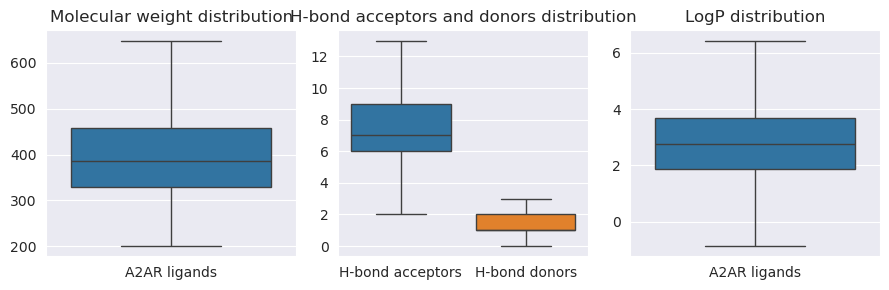

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # Adjust figsize as needed

sns.boxplot(y=mw, showfliers=False, ax=axes[0])
axes[0].set(xticklabels=['A2AR ligands'], title='Molecular weight distribution')

sns.boxplot(data=[hba, hbd], showfliers=False, ax=axes[1])
axes[1].set(xticklabels=['H-bond acceptors', 'H-bond donors'], title='H-bond acceptors and donors distribution')

sns.boxplot(y=logp, showfliers=False, ax=axes[2])
axes[2].set(xticklabels=['A2AR ligands'], title='LogP distribution')

plt.tight_layout()
plt.show()

How many cmpds are within rule of 5 for lead-likeness?

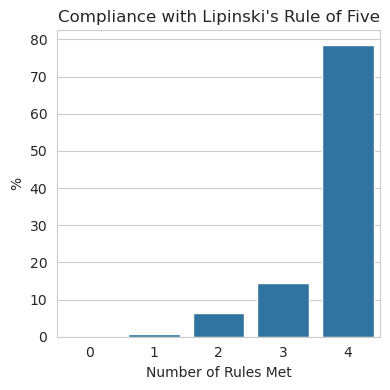

In [8]:
count_0, count_1, count_2, count_3, count_4 = 0, 0, 0, 0, 0

for smi in a2ar["SMILES"]:
    mol = Chem.MolFromSmiles(smi)
    MW = Descriptors.MolWt(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    HBD = Descriptors.NumHDonors(mol)
    LogP = Descriptors.MolLogP(mol)

    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]

    if conditions.count(True) == 4:
        count_4 += 1
    elif conditions.count(True) == 3:
        count_3 += 1
    elif conditions.count(True) == 2:
        count_2 += 1
    elif conditions.count(True) == 1:
        count_1 += 1
    elif conditions.count(True) == 0:
        count_0 += 1

total = sum([count_0, count_1, count_2, count_3, count_4])
perc = [c / total * 100 for c in [count_0, count_1, count_2, count_3, count_4]]
labels = ['0', '1', '2', '3', '4']

sns.set_style("whitegrid")
plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=perc)
plt.title("Compliance with Lipinski's Rule of Five")
plt.ylabel("%")
plt.xlabel("Number of Rules Met")
plt.tight_layout()
plt.show()

Check the rules of lead-likeness

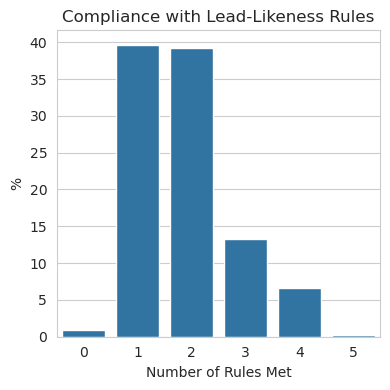

In [9]:
count_0, count_1, count_2, count_3, count_4, count_5 = 0, 0, 0, 0, 0, 0

for smi in a2ar["SMILES"]:
    mol = Chem.MolFromSmiles(smi)
    MW = Descriptors.MolWt(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    HBD = Descriptors.NumHDonors(mol)
    LogP = Descriptors.MolLogP(mol)
    Rot = rdMolDescriptors.CalcNumRotatableBonds(mol)

    conditions = [MW <= 300, HBA <= 3, HBD <= 3, LogP <= 3, Rot <= 3]

    if conditions.count(True) == 5:
        count_5 += 1
    elif conditions.count(True) == 4:
        count_4 += 1
    elif conditions.count(True) == 3:
        count_3 += 1
    elif conditions.count(True) == 2:
        count_2 += 1
    elif conditions.count(True) == 1:
        count_1 += 1
    elif conditions.count(True) == 0:
        count_0 += 1

total = sum([count_0, count_1, count_2, count_3, count_4, count_5])
perc = [c / total * 100 for c in [count_0, count_1, count_2, count_3, count_4, count_5]]
labels = ['0', '1', '2', '3', '4', '5']
sns.set_style("whitegrid")
plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=perc)
plt.title("Compliance with Lead-Likeness Rules")
plt.ylabel("%")
plt.xlabel("Number of Rules Met")
plt.tight_layout()
plt.show()

Are most active compounds more drug-like?

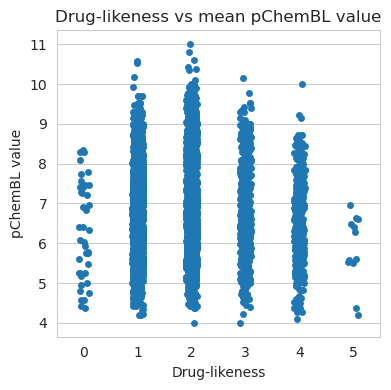

In [10]:
dl = []
pchembl = []

for _, row in a2ar.iterrows():
    smi = row["SMILES"]
    pch = row["pchembl_value_Mean"]

    mol = Chem.MolFromSmiles(smi)

    MW = Descriptors.MolWt(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    HBD = Descriptors.NumHDonors(mol)
    LogP = Descriptors.MolLogP(mol)
    Rot = rdMolDescriptors.CalcNumRotatableBonds(mol)

    rules_met = sum([MW <= 300, HBA <= 3, HBD <= 3, LogP <= 3, Rot <= 3])
    dl.append(rules_met)
    pchembl.append(pch)

df = pd.DataFrame({'pChemBL': pchembl, 'Drug-like': dl})

sns.set_style("whitegrid")
plt.figure(figsize=(4, 4))
sns.stripplot(x='Drug-like', y='pChemBL', data=df)
plt.title("Drug-likeness vs mean pChemBL value")
plt.ylabel("pChemBL value")
plt.xlabel("Drug-likeness")
plt.tight_layout()
plt.show()

Conclusion: Mean pCHEMBL value is not correlated with drug-likeness

# Scaffold analysis

## PAINS

In [11]:
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags

In [ ]:
# create a namedtuple containing the pattern name and number of occurences in my ds
PainsInfo = namedtuple("PainsInfo", ["pattern_name", "num_occurences"])
pains_info = []
for p in pains:
    found = 0
    p_mol = p[0]
    p_text = p[1]
    for i, row in a2ar.iterrows():
        mol = Chem.MolFromSmiles(row.SMILES)
        if mol.HasSubstructMatch(p_mol):
            found += 1

    pains_info.append(PainsInfo(p_text, found))

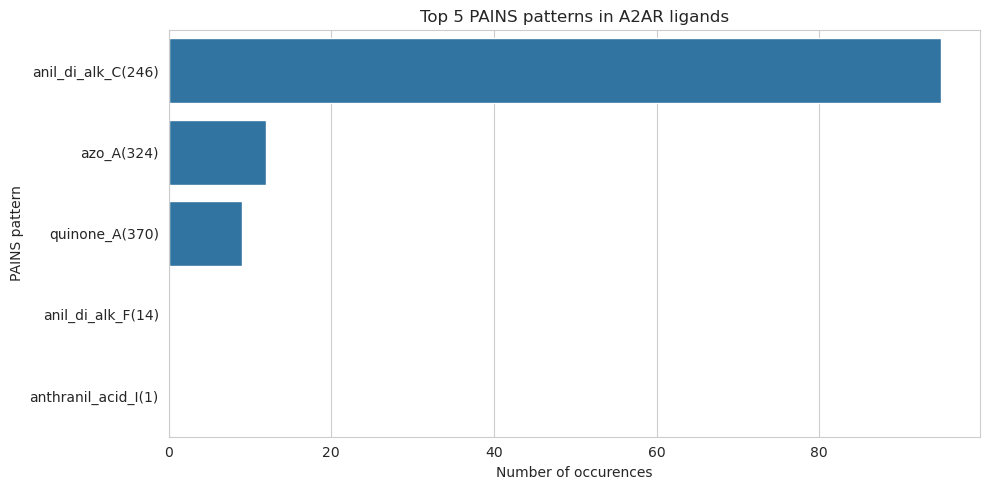

In [10]:
# see which PAINS are most common and display in a plot
pains_info = pd.DataFrame(pains_info)
pains_info.columns = ['pattern_name', 'num_occurences']
pains_info = pains_info.sort_values(by='num_occurences', ascending=False)
top10 = pains_info[:5]
plt.figure(figsize=(10, 5))
sns.barplot(x='num_occurences', y='pattern_name', data=top10)
plt.title("Top 5 PAINS patterns in A2AR ligands")
plt.xlabel("Number of occurences")
plt.ylabel("PAINS pattern")
plt.tight_layout()
plt.show()

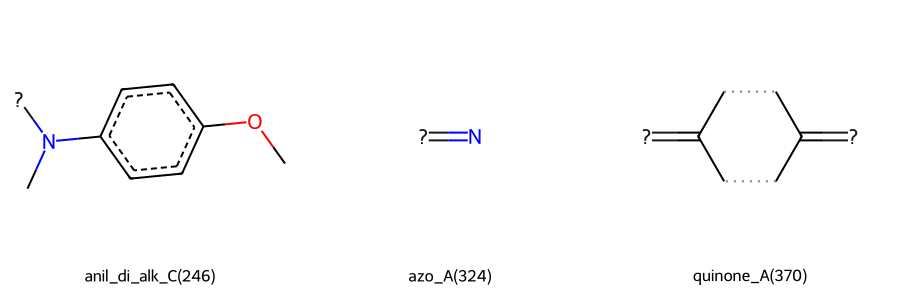

In [11]:
pains_found = ["anil_di_alk_C(246)", "azo_A(324)", "quinone_A(370)"]
found_mols = [(p[0], p[1]) for p in pains if p[1] in pains_found]
found_mols = sorted(found_mols, key=lambda x: pains_found.index(x[1]))  # lamba used to preserve the same order as in the list
mols = [mol for mol, _ in found_mols]
legends = [name for _, name in found_mols]

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)
display(img)

## Most common scaffolds

In [12]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereochemistry
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

In [13]:
# create new column with scaffold, convert to SMILES
a2ar['scaffold'] = a2ar['SMILES'].apply(lambda x: Chem.MolToSmiles(scaffold(Chem.MolFromSmiles(x))))

In [14]:
# See how many unique scaffolds are in the dataset
scaffolds = a2ar['scaffold'].unique()
print(f"Number of unique scaffolds: {len(scaffolds)}")

Number of unique scaffolds: 796


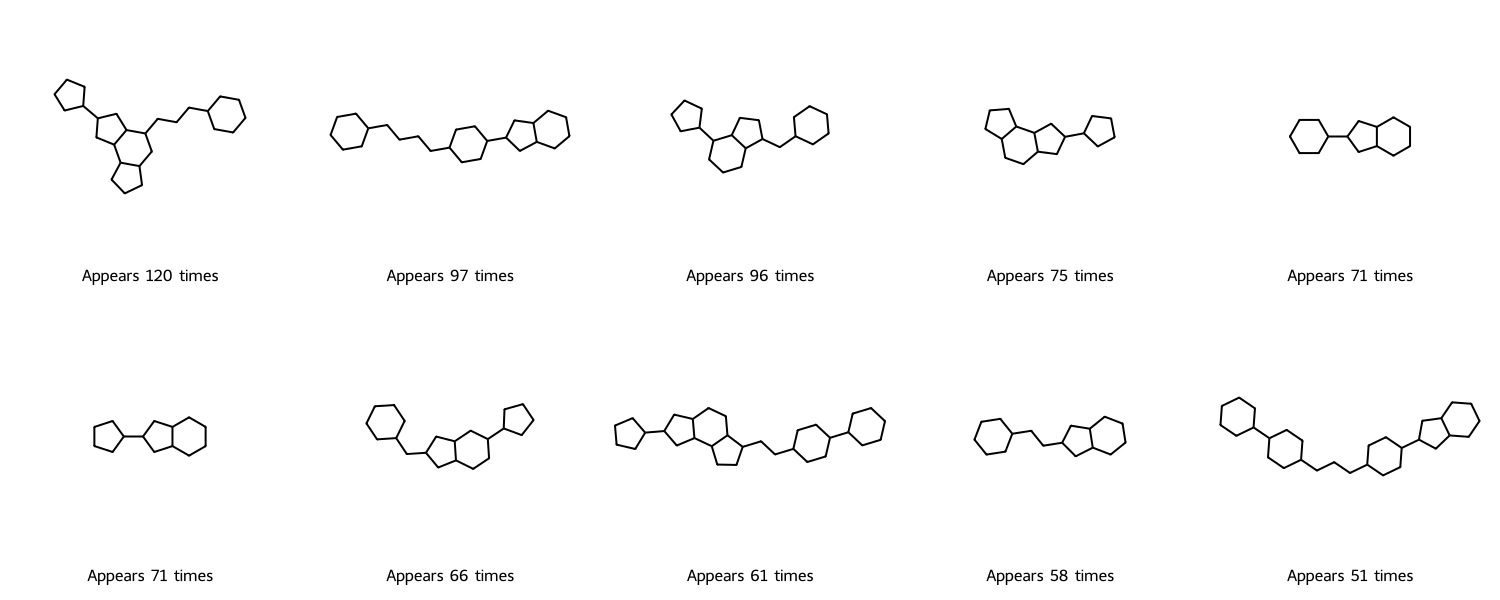

In [15]:
# Display the most common scaffolds
scaffold_counts = a2ar['scaffold'].value_counts()
top_scaffolds = scaffold_counts.head(10)
top_scaffolds = top_scaffolds.reset_index()
top_scaffolds.columns = ['scaffold', 'count']
img = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in top_scaffolds['scaffold']],
                           molsPerRow=5, subImgSize=(300, 300),
                           legends=[f'Appears {count} times' for count in top_scaffolds['count']])
display(img)


# Chemical space visualization

I will calculate 2 types of binary fingerprints: <br>
1. Morgan fps
2. Pharmacophore fps

In [16]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
mfps = []

for _, row in a2ar.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    fp = mfpgen.GetFingerprint(mol)
    fp_array = np.zeros((1,))
    ConvertToNumpyArray(fp, fp_array)
    mfps.append(fp_array)

In [17]:
factory = SigFactory(ChemicalFeatures.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')),minPointCount=2, maxPointCount=3)
factory.SetBins([(0, 1), (1, 3), (3, 5), (5, 8), (8, 100)])
factory.skipFeats = ['ZnBinder']  # this is a very specific feature unimportant for our target
factory.Init()
ph4_fps = []

for _, row in a2ar.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    sparsefp = Generate.Gen2DFingerprint(mol, factory)
    fp = ExplicitBitVect(sparsefp.GetNumBits())
    for bit in sparsefp.GetOnBits():
        fp.SetBit(bit)
    fp_array = np.zeros((1,))
    ConvertToNumpyArray(fp, fp_array)
    ph4_fps.append(fp_array)

In [18]:
pca = decomposition.PCA(n_components=42)
pca_mfps = pca.fit_transform(mfps)
pca_ph4_fps = pca.fit_transform(ph4_fps)

In [19]:
pca_mfps

array([[-0.26492573, -0.31990594, -0.61783591, ..., -0.07351755,
        -0.21296047,  0.24346339],
       [-0.51173902, -0.35643867, -1.27689387, ...,  0.75249134,
         0.34397807, -0.06783502],
       [-0.64667488, -0.62544058, -0.45880756, ...,  0.36720736,
        -0.10806563, -0.09224312],
       ...,
       [-0.84616658, -0.33462788, -1.73907762, ...,  0.5259926 ,
         0.43136186,  0.04772735],
       [-1.23166542, -1.63988037,  0.85015718, ..., -0.2364899 ,
         0.54004865, -0.19599784],
       [ 3.1819974 ,  0.47991017,  0.57775072, ..., -0.24807805,
        -0.83056885, -0.10201704]])

Text(0.5, 1.0, 'PCA - Morgan fingerprints')

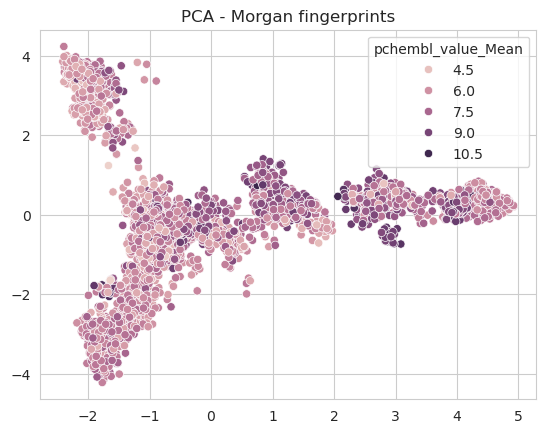

In [20]:
cl = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward')
cl.fit(pca_mfps)
ax = sns.scatterplot(x=pca_mfps[:, 0], y=pca_mfps[:, 1], hue=a2ar['pchembl_value_Mean'])
ax.set_title('PCA - Morgan fingerprints')

Text(0.5, 1.0, 'PCA - Pharmacophore fingerprints')

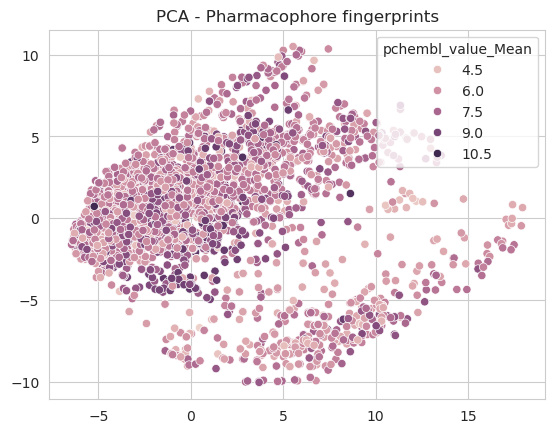

In [21]:
cl = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward')
cl.fit(pca_ph4_fps)
ax = sns.scatterplot(x=pca_ph4_fps[:, 0], y=pca_ph4_fps[:, 1], hue=a2ar['pchembl_value_Mean'])
ax.set_title('PCA - Pharmacophore fingerprints')

Text(0.5, 1.0, 'UMAP - Morgan fingerprints')

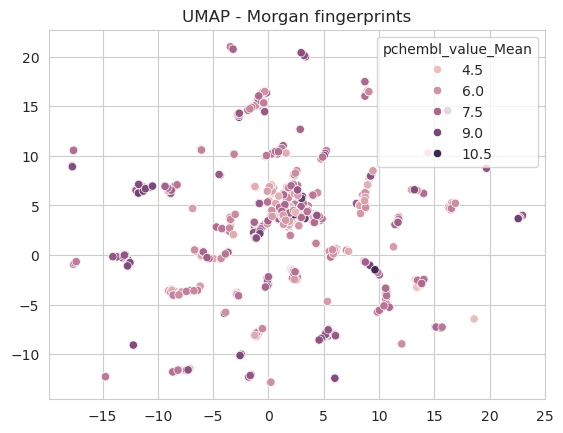

In [22]:
fit = umap.UMAP()
fit_fps = fit.fit_transform(pca_mfps)
ax = sns.scatterplot(x=fit_fps[:, 0], y=fit_fps[:, 1], hue=a2ar['pchembl_value_Mean'])
ax.set_title('UMAP - Morgan fingerprints')

Text(0.5, 1.0, 'UMAP - Pharmacophore fingerprints')

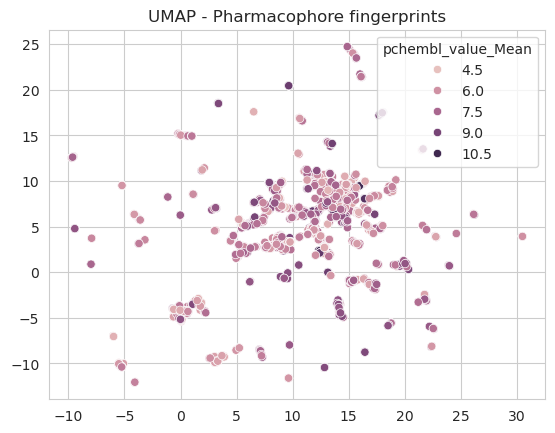

In [23]:
fit_ph4 = fit.fit_transform(pca_ph4_fps)
ax = sns.scatterplot(x=fit_ph4[:, 0], y=fit_ph4[:, 1], hue=a2ar['pchembl_value_Mean'])
ax.set_title('UMAP - Pharmacophore fingerprints')

# ML

My dataset was cleaned already, so I will not do it again. <br>

In [24]:
# Random split

train, test = train_test_split(a2ar, test_size=0.2, random_state=42)
train_smi = np.array(train['SMILES'])
test_smi = np.array(test['SMILES'])
train_y = np.array(train['pchembl_value_Mean'])
test_y = np.array(test['pchembl_value_Mean'])

#featurize to get train_x and test_x
train_x = []
for smi in train_smi:
    mol = Chem.MolFromSmiles(smi)
    fp = ExplicitBitVect(sparsefp.GetNumBits())
    for bit in sparsefp.GetOnBits():
        fp.SetBit(bit)
    fp_array = np.zeros((1,))
    ConvertToNumpyArray(fp, fp_array)
    train_x.append(fp_array)

test_x = []
for smi in test_smi:
    mol = Chem.MolFromSmiles(smi)
    fp = ExplicitBitVect(sparsefp.GetNumBits())
    for bit in sparsefp.GetOnBits():
        fp.SetBit(bit)
    fp_array = np.zeros((1,))
    ConvertToNumpyArray(fp, fp_array)
    test_x.append(fp_array)

train_x, train_y, test_x, test_y = np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

In [25]:
params_grid_XGB = {
    "n_estimators": [100, 250, 500],
    "max_depth": [None, 5, 10, 40],
    "learning_rate": [0.01, 0.05, 0.1],
    "gamma": [0, 0.2, 0.4]}

In [26]:
def grid_search(model, params_grid, sample_size, train_x, train_y, test_x, test_y):
    r"""Does CV grid search for the model and returns the best params and model
    Args:
        model: model to be trained
        params_grid: dict with params to be tested
        sample_size: number of random combinations to be tested
        train_x: training data
        train_y: training labels
        test_x: test data
        test_y: test labels
    """

    best_rmse = 10000  # arbitrary high value
    params_combinations = sample(list(ParameterGrid(params_grid)), sample_size)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_model= None
    i = 1

    for item in params_combinations:
        print(f"Grid search iteration {i}, params: {item}")
        i += 1
        fold = 1
        model.set_params(**item)
        for train_index, val_index in kf.split(train_x):
            fold_model = clone(model)  # fresh model for each fold
            X_train, X_val = train_x[train_index], train_x[val_index]
            y_train, y_val = train_y[train_index], train_y[val_index]
            fold_model.fit(X_train, y_train)

            preds = fold_model.predict(X_val)
            val_rmse = np.sqrt(np.mean((preds - y_val) ** 2))
            print(f"Fold {fold}, RMSE: {val_rmse}")
            fold += 1
            if best_rmse > val_rmse:
                best_rmse = val_rmse
                best_model = model
                best_params = {**item, "best_rmse": best_rmse}
                print(f'New best RMSE: {best_rmse}')

    return best_model, best_params

In [27]:
best_model, best_params = grid_search(XGBRegressor(), params_grid_XGB, 20, train_x, train_y, test_x, test_y)

Grid search iteration 1, params: {'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 40, 'n_estimators': 100}
Fold 1, RMSE: 1.1589481189688482
New best RMSE: 1.1589481189688482
Fold 2, RMSE: 1.1776359826707776
Fold 3, RMSE: 1.149109773302692
New best RMSE: 1.149109773302692
Fold 4, RMSE: 1.1373043031710997
New best RMSE: 1.1373043031710997
Fold 5, RMSE: 1.172413403673759
Grid search iteration 2, params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Fold 1, RMSE: 1.1589481189688482
Fold 2, RMSE: 1.1776359826707776
Fold 3, RMSE: 1.149109773302692
Fold 4, RMSE: 1.1373043031710997
Fold 5, RMSE: 1.172413403673759
Grid search iteration 3, params: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 40, 'n_estimators': 500}
Fold 1, RMSE: 1.1589481189688482
Fold 2, RMSE: 1.1776359826707776
Fold 3, RMSE: 1.149109773302692
Fold 4, RMSE: 1.1373043031710997
Fold 5, RMSE: 1.172413403673759
Grid search iteration 4, params: {'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 40,

In [28]:
best_params

{'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 40,
 'n_estimators': 100,
 'best_rmse': 1.1373043031710997}

In [29]:
best_model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
best_model.score(test_x, test_y)  # negative score means that the model is worse than simply calculating the mean for all

-0.00011022638670321605

Let's see if Random Forest will be better

In [33]:
params_grid_RF = {
    "n_estimators": [100, 250, 500],
    "max_depth": [None, 5, 10, 40],
    "min_samples_split": [2, 10, 15, 30, 60]
}

In [3]:
best_model, best_params = grid_search(RandomForestRegressor(), params_grid_RF, 20, train_x, train_y, test_x, test_y)

NameError: name 'grid_search' is not defined

In [1]:
best_model.fit(train_x, train_y)

NameError: name 'best_model' is not defined

In [2]:
best_model.score(test_x, test_y)  # that is even worse..

NameError: name 'best_model' is not defined